In [174]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=3, style='white')

In [175]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [176]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [177]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"
mapping01["param__func__de.upb.lb-nginx.0.1__mem_max"] = "Memory"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"
mapping02["param__func__de.upb.lb-haproxy.0.1__mem_max"] = "Memory"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"
mapping03["param__func__de.upb.px-squid.0.1__mem_max"] = "Memory"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [178]:
# select sub-datasets with small and large flows
# and with specific memory
mem = 128

web1_small = web1.loc[(web1["size"] == "small") & (web1["Memory"] == mem)]
web1_small = web1_small[["Max. throughput [kB/s]", "CPU"]]
web1_big = web1.loc[(web1["size"] == "big")  & (web1["Memory"] == mem)]
web1_big = web1_big[["Max. throughput [kB/s]", "CPU"]]

web2_small = web2.loc[(web2["size"] == "small")  & (web2["Memory"] == mem)]
web2_small = web2_small[["Max. throughput [kB/s]", "CPU"]]
web2_big = web2.loc[(web2["size"] == "big")  & (web2["Memory"] == mem)]
web2_big = web2_big[["Max. throughput [kB/s]", "CPU"]]

web3_small = web3.loc[(web3["size"] == "small")  & (web3["Memory"] == mem)]
web3_small = web3_small[["Max. throughput [kB/s]", "CPU"]]
web3_big = web3.loc[(web3["size"] == "big")  & (web3["Memory"] == mem)]
web3_big = web3_big[["Max. throughput [kB/s]", "CPU"]]

In [179]:
# 20 measurements per CPU config from 0.1 to 1.0
web1_small[web1_small["CPU"] == 0.5].shape

(20, 2)

In [180]:
# add 20 "measurements" at 0 CPU and throuhgput
num_measures = 20
measures = [0 for _ in range(num_measures)]

web1_small = web1_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web1_big = web1_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web2_small = web2_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web2_big = web2_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_small = web3_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_big = web3_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)

In [181]:
# rename
nginx = web1_small
haproxy = web2_small
squid = web3_small

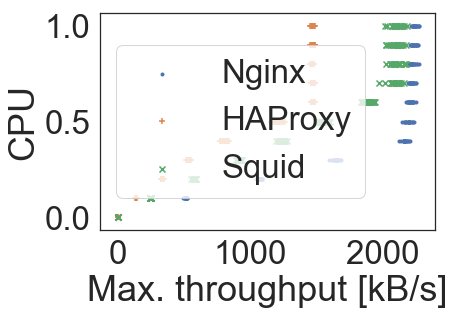

In [182]:
# proper plotting of VNF data for paper
# only use data with small flows
def plot_vnf_data():
    fig, ax = plt.subplots()
    plt.scatter(nginx['Max. throughput [kB/s]'], nginx['CPU'], label='Nginx', marker='.')
    plt.scatter(haproxy['Max. throughput [kB/s]'], haproxy['CPU'], label='HAProxy', marker='+')
    plt.scatter(squid['Max. throughput [kB/s]'], squid['CPU'], label='Squid', marker='x')

    # labels
    ax.set_xlabel('Max. throughput [kB/s]')
    ax.set_ylabel('CPU')
    plt.legend()
    
    fig.savefig(f'plots/web_vnf_data.pdf', bbox_inches='tight')
    
plot_vnf_data()

In [183]:
def cross_validation_rmse(model, X, y, vnf_name, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/{vnf_name}/{name}.joblib')
    return rmse 

def tune_hyperparams(model, X, y, params):
    """Do grid search CV for hyperparam tuning and return CV RMSE"""
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)   
    return grid_search.best_estimator_

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    sns.set(font_scale=3, style='white')
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots(figsize = (8, 6))
    plt.barh(x, rmse_mean, color='grey', xerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('RMSE')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

In [184]:
def train_eval_models(X, y, vnf_name, tune_params=False):
    """Create, tune, eval, and return all ML models"""
    # prepare models
    labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
    models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
              GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
              FixedModel(fixed_value=0.8)]
    
    # params for tuning
    params_ridge = {'alpha': [0.1, 1, 10]}
    params_svr = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100], 
                  'epsilon': [0.001, 0.01, 0.1]}
    params_forest = {'n_estimators': [10, 100, 200]}
    params_boosting = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [10, 100, 200]}
    params_mlp = {'hidden_layer_sizes': [(64,), (128,), (256)], 'alpha': [0.001, 0.0001, 0.00001],
                  'learning_rate_init': [0.01, 0.001, 0.0001]}
    params = [{}, params_ridge, params_svr, params_forest, params_boosting, params_mlp, {}]
    
    # tune, train, eval
    if tune_params:
        models = [tune_hyperparams(models[i], X_scaled, y, params[i]) for i in range(len(models))]
    rmse = [cross_validation_rmse(model, X, y, vnf_name, save_model=True) for model in models]
    
    # plot
    if tune_params:
        barplot_rmse(rmse, labels, f'{vnf_name}_tuned')
    else:
        barplot_rmse(rmse, labels, f'{vnf_name}_default')
        
    return models

In [185]:
def prepare_data(data, vnf_name):
    """Split return data"""
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X = X.fillna(X.median())

    scaler = MinMaxScaler()
    scaler.fit(X)
    os.makedirs(f'ml_models/{vnf_name}', exist_ok=True)
    joblib.dump(scaler, f'ml_models/{vnf_name}/scaler.joblib')
    
    return X, y, scaler

In [186]:
def predict_plot_all(models, scaler, X, y, vnf_name):
    """Given a list of models, fit all to the data, save model, and plot their predictions"""
    sns.set(font_scale=1.5, style='white')
    
    models = [models[0], models[2], models[3], models[6]]
    labels = ['Linear', 'SVR', 'Boosting', 'Fixed']
    markers = ['x', 'v', '^', '+']
    colors = ['blue', 'orange', 'red', 'green']
    
    fig, ax = plt.subplots()    
    plt.scatter(X, y, label='True', marker='o', color='black', s=50)
    X = scaler.transform(X)
    for i, model in enumerate(models):
        # train model
        name = type(model).__name__
        model.fit(X, y)
        os.makedirs(f'ml_models/{vnf_name}', exist_ok=True)
        # predict and plot data
        X_plot = pd.DataFrame({'Max. throughput [kB/s]': np.arange(200, 2500, 50)})
        X_plot_scaled = scaler.transform(X_plot)
        y_pred = model.predict(X_plot_scaled)
        plt.scatter(X_plot, y_pred, label=labels[i], marker=markers[i], color=colors[i])
    plt.xlabel('Max. throughput [kB/s]')
    plt.ylabel('CPU')
    plt.legend()
    # save, avoid cutting off labels
    plt.tight_layout()
    fig.savefig(f'plots/{vnf_name}_model_comparison.pdf')

CV RMSE of LinearRegression: 0.19651294327683955 (+/-0.0770302015503735)
CV RMSE of Ridge: 0.19747963738692514 (+/-0.07374557483743582)
CV RMSE of SVR: 0.1829420132476261 (+/-0.08049356087609329)
CV RMSE of RandomForestRegressor: 0.15314239789450718 (+/-0.04167509928244082)
CV RMSE of GradientBoostingRegressor: 0.14334186263227305 (+/-0.0379499323771591)
CV RMSE of MLPRegressor: 0.18164842799137587 (+/-0.07022434004074095)
CV RMSE of FixedModel: 0.38153965300099446 (+/-0.21077830340877302)


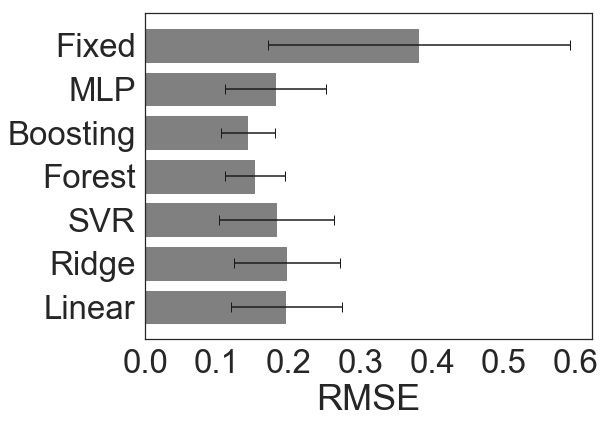

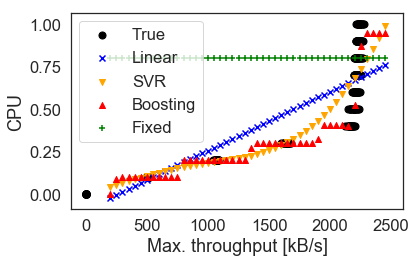

In [187]:
vnf_name = 'nginx'
X, y, scaler = prepare_data(nginx, vnf_name)

models = train_eval_models(scaler.transform(X), y, vnf_name, tune_params=True)
predict_plot_all(models, scaler, X, y, vnf_name)

CV RMSE of LinearRegression: 0.1007619172166632 (+/-0.048577241001214605)
CV RMSE of Ridge: 0.09846542319497902 (+/-0.054905281452056726)
CV RMSE of SVR: 0.08072140672886818 (+/-0.05972576935870195)
CV RMSE of RandomForestRegressor: 0.14547408844983828 (+/-0.059968096053101765)
CV RMSE of GradientBoostingRegressor: 0.13926055521135733 (+/-0.06359073931167565)
CV RMSE of MLPRegressor: 0.11683391231212151 (+/-0.04209348994954398)
CV RMSE of FixedModel: 0.38153965300099446 (+/-0.21077830340877302)


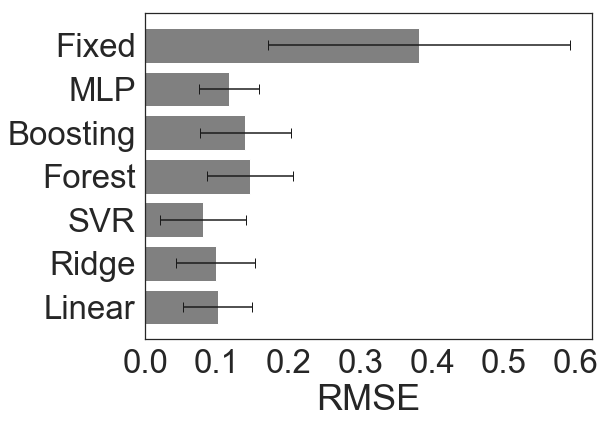

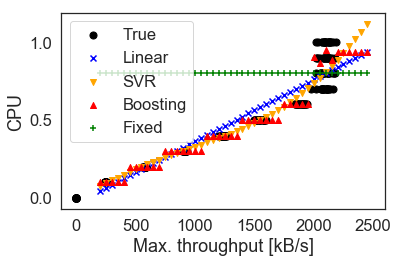

In [188]:
vnf_name = 'squid'
X, y, scaler = prepare_data(squid, vnf_name)

models = train_eval_models(scaler.transform(X), y, vnf_name, tune_params=True)
predict_plot_all(models, scaler, X, y, vnf_name)